In [ ]:
pip install osmnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.2/107.2 kB 3.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import random
import seaborn as sns

                speed  travel_time    status        id   link_id
speed        1.000000    -0.107775  0.687263  0.151602 -0.170095
travel_time -0.107775     1.000000  0.284398 -0.136645 -0.075264
status       0.687263     0.284398  1.000000  0.077344 -0.212812
id           0.151602    -0.136645  0.077344  1.000000 -0.044232
link_id     -0.170095    -0.075264 -0.212812 -0.044232  1.000000


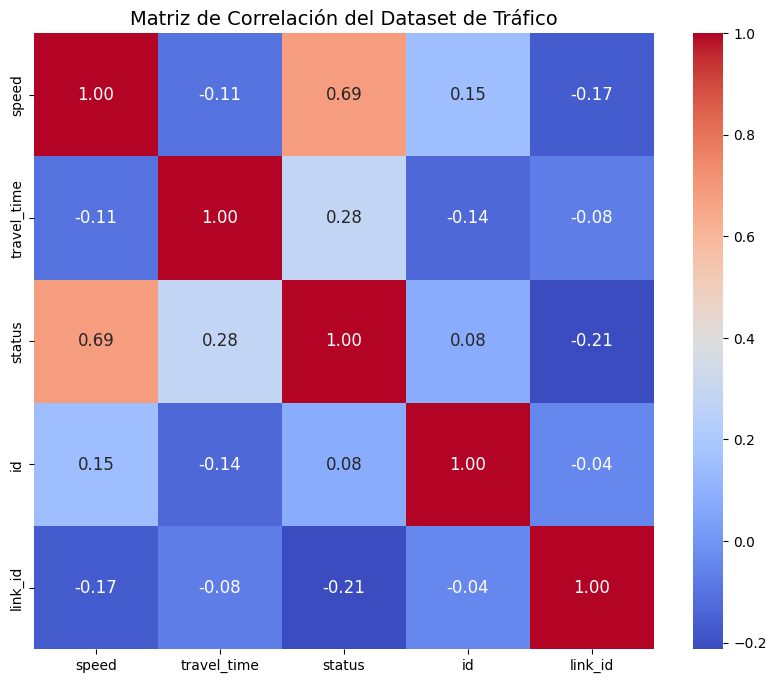

In [ ]:

# Descargar datos de volumen de tráfico de NYC Open Data
traffic_data_url = "https://data.cityofnewyork.us/resource/i4gi-tjb9.csv"
traffic_data = pd.read_csv(traffic_data_url)
relevant_columns = ['speed', 'travel_time', 'status', 'id', 'link_id']

traffic_data_filtered = traffic_data[relevant_columns].apply(pd.to_numeric, errors='coerce')

traffic_data_filtered = traffic_data_filtered.dropna()
correlation_matrix = traffic_data_filtered.corr()
print(correlation_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación del Dataset de Tráfico')
plt.show()


In [ ]:
traffic_data['link_points'].value_counts()

link_points
40.63092,-74.14592 40.62975,-74.14593 40.62877,-74.14579 40.6279506,-74.145671 40.62713,-74.145681 40.62637,-74.14586 40.6254205,-74.14618 40.6247506,-74.146381 40.6241006,-74.146661 40.6234004,-74.14704 40.6226006,-74.147501 40.6217506,-74.148181 40.6208    18
40.77223,-73.919941 40.77367,-73.92198 40.7744206,-73.92278 40.77714,-73.924911 40.781071,-73.92788 40.78311,-73.929421 40.7837106,-73.929871 40.7842205,-73.93008 40.78477,-73.93017 40.78549,-73.93011 40.78604,-73.92991 40.78665,-73.92953 40.78972,-73.926    16
40.683644,-73.72667001  40.68314,-73.72692  40.681365,-73.72806  40.678944,-73.72983  40.678236,-73.73047001  40.67642,-73.73234001  40.67526,-73.7334  40.673794,-73.73464001  40.672886,-73.73533  40.668966,-73.73805  40.668534,-73.73831  40.66749,-73.739     9
40.81376,-73.93128 40.8127206,-73.9316 40.8121104,-73.93169 40.81148,-73.93161 40.81091,-73.931261 40.81044,-73.93079 40.8082604,-73.927901 40.80772,-73.9269 40.80653,-73.923971 40.80503,-73.92024 40.80

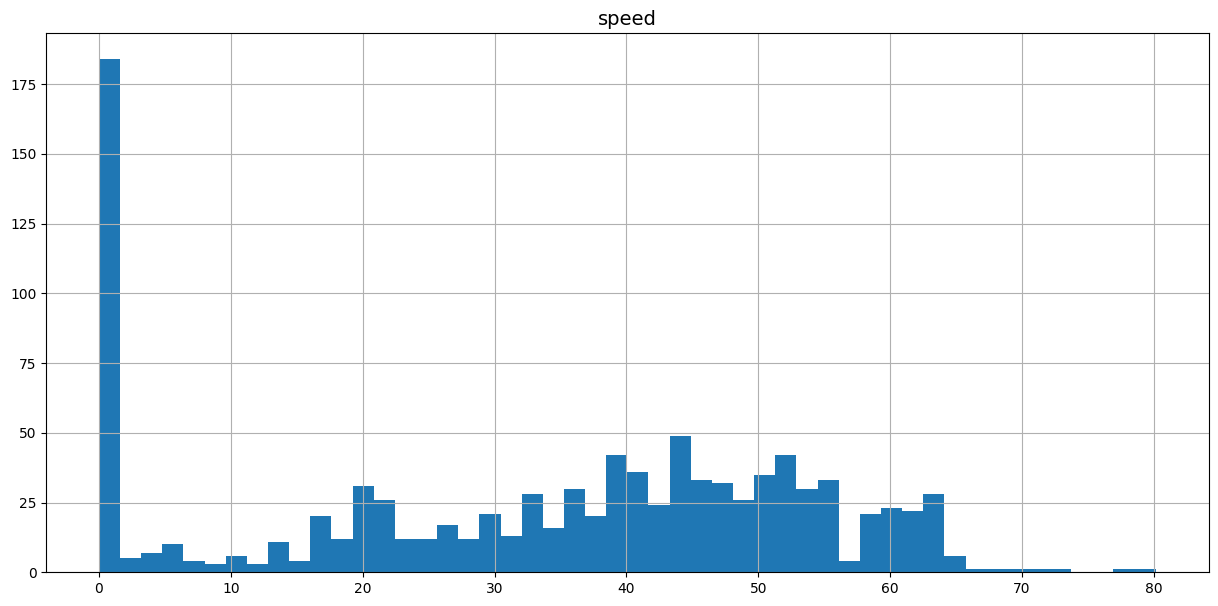

In [ ]:

plt.rc('font',size=12)
plt.rc('axes', labelsize=12, titlesize=14)
plt.rc('legend',fontsize=14)
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=10)
traffic_data.hist(bins=50,figsize=(15,7))
plt.show()

In [ ]:
traffic_data.isnull().sum()

link_points    0
speed          0
dtype: int64

In [ ]:

print("\nInformación del dataset:")
print(traffic_data['link_points'].info())
print(traffic_data['link_points'].head())

print("\nEstadísticas descriptivas del dataset:")
print(traffic_data.describe())



Información del dataset:
<class 'pandas.core.series.Series'>
RangeIndex: 1000 entries, 0 to 999
Series name: link_points
Non-Null Count  Dtype 
--------------  ----- 
1000 non-null   object
dtypes: object(1)
memory usage: 7.9+ KB
None
0    40.683644,-73.72667001  40.68314,-73.72692  40...
1    40.56058,-74.199581 40.568141,-74.192011 40.57...
2    40.6210105,-74.168861 40.6207604,-74.168 40.61...
3    40.7278806,-73.832761 40.7270705,-73.83231 40....
4    40.6152105,-74.157401 40.61231,-74.15362 40.60...
Name: link_points, dtype: object

Estadísticas descriptivas del dataset:
             speed
count  1000.000000
mean     32.773720
std      20.812006
min       0.000000
25%      17.390000
50%      37.900000
75%      49.700000
max      80.150000


(<Figure size 1200x1200 with 1 Axes>, <Axes: >)

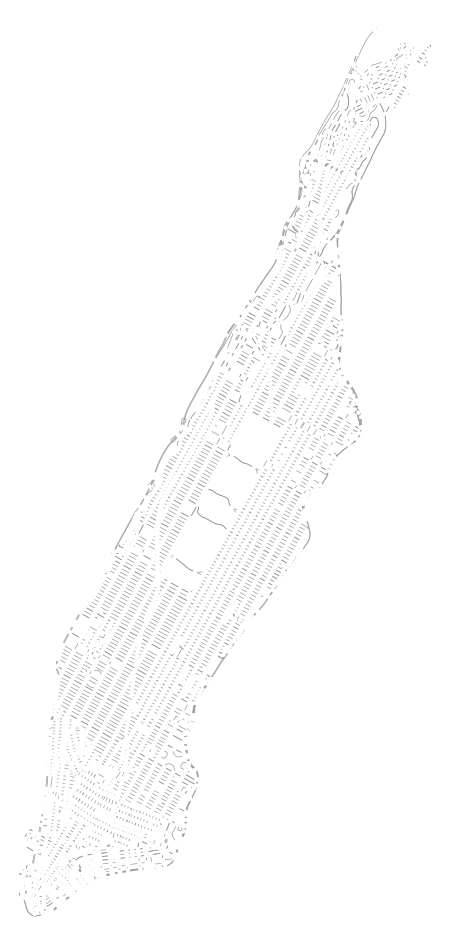

In [ ]:

# Filtrar las columnas necesarias
traffic_data = traffic_data[['link_points', 'speed']]

# Configuración de osmnx
ox.settings.use_cache = True
ox.settings.log_console = True

# Definir el lugar de interés (en este caso, Manhattan, Nueva York)
place_name = "Manhattan, New York, USA"

# Descargar el grafo de la red de calles desde OpenStreetMap
G = ox.graph_from_place(place_name, network_type='drive')
fig, ax = plt.subplots(figsize=(12, 12))
ox.plot_graph(G, node_size=10, edge_linewidth=0.5, show=False, ax=ax)


In [ ]:

# Función para extraer coordenadas del campo 'link_points' y validar que sean correctas
def extract_coordinates(link_points):
    points = link_points.split()
    valid_points = []
    for point in points:
        try:
            coords = tuple(map(float, point.split(',')))
            if len(coords) == 2:
                valid_points.append(coords)
        except ValueError:
            continue
    if len(valid_points) >= 2:
        return valid_points[0], valid_points[-1]
    else:
        return None, None

# Asignar propiedades de tráfico basadas en los datos descargados
for index, row in traffic_data.iterrows():
    start_coords, end_coords = extract_coordinates(row['link_points'])
    if start_coords and end_coords:
        try:
            start_node = ox.distance.nearest_nodes(G, start_coords[1], start_coords[0])
            end_node = ox.distance.nearest_nodes(G, end_coords[1], end_coords[0])
            if G.has_edge(start_node, end_node):
                G[start_node][end_node][0]['traffic'] = row['speed']
                G[start_node][end_node][0]['weight'] = G[start_node][end_node][0]['length'] / row['speed']
            elif G.has_edge(end_node, start_node):
                G[end_node][start_node][0]['traffic'] = row['speed']
                G[end_node][start_node][0]['weight'] = G[end_node][start_node][0]['length'] / row['speed']
        except Exception as e:
            continue
#Este for verifica que los valores a los que no se les asigno las aristas se les asigne de tal manera que el trafico es igual a la
#velocidad permitida de manera randomica entre valores de 15 kmph a 50
for u, v, data in G.edges(data=True):
    if 'traffic' not in data:
      data['traffic'] = random.randint(15, 50)
    if 'weight' not in data:
      data['weight'] = data['length'] * data['traffic']

<ipython-input-53-000aa53c73d4>:26: RuntimeWarning: divide by zero encountered in scalar divide
  G[start_node][end_node][0]['weight'] = G[start_node][end_node][0]['length'] / row['speed']
<ipython-input-53-000aa53c73d4>:26: RuntimeWarning: divide by zero encountered in scalar divide
  G[start_node][end_node][0]['weight'] = G[start_node][end_node][0]['length'] / row['speed']
<ipython-input-53-000aa53c73d4>:26: RuntimeWarning: divide by zero encountered in scalar divide
  G[start_node][end_node][0]['weight'] = G[start_node][end_node][0]['length'] / row['speed']
<ipython-input-53-000aa53c73d4>:26: RuntimeWarning: divide by zero encountered in scalar divide
  G[start_node][end_node][0]['weight'] = G[start_node][end_node][0]['length'] / row['speed']
<ipython-input-53-000aa53c73d4>:26: RuntimeWarning: divide by zero encountered in scalar divide
  G[start_node][end_node][0]['weight'] = G[start_node][end_node][0]['length'] / row['speed']
<ipython-input-53-000aa53c73d4>:26: RuntimeWarning: div

In [ ]:

def bee_algorithm(G, start_node, end_node, num_bees=50, num_iterations=100):
    best_path = None
    best_path_length = float('inf')

    for iteration in range(num_iterations):
        paths = []
        path_lengths = []

        for bee in range(num_bees):
            try:
                path = nx.shortest_path(G, source=start_node, target=end_node, weight='weight')
                path_length = nx.shortest_path_length(G, source=start_node, target=end_node, weight='weight')
                paths.append(path)
                path_lengths.append(path_length)

                # Simular el comportamiento de exploración y explotación
                if random.random() < 0.1:  # 10% de probabilidad de exploración
                    u, v = random.choice(list(G.edges()))
                    if 'traffic' in G[u][v]:
                        G[u][v]['traffic'] = max(1, G[u][v]['traffic'] - 1)  # Reducir tráfico como recompensa

            except nx.NetworkXNoPath:
                # No hay camino entre los nodos en esta iteración
                continue

        if paths:
            min_length_index = path_lengths.index(min(path_lengths))

            if path_lengths[min_length_index] < best_path_length:
                best_path = paths[min_length_index]
                best_path_length = path_lengths[min_length_index]

            # Incrementar tráfico en todas las aristas utilizadas en esta iteración (penalización)
            for path in paths:
                for i in range(len(path) - 1):
                    u, v = path[i], path[i + 1]
                    if 'traffic' in G[u][v]:
                        G[u][v]['traffic'] += 1

    print(f"Número de iteraciones: {num_iterations}")
    # Imprimir histograma de rendimiento
    plt.hist(path_lengths)
    plt.xlabel("Longitud del camino")
    plt.ylabel("Frecuencia")
    plt.title("Histograma de rendimiento del algoritmo de forrajeo de abejas")
    plt.show()

    return best_path, best_path_length


***Pruebas con puntos cartecianos para el algoritmo***
-- --
1. Times Square:

* Inicio: (40.7580, -73.9855)
* Fin: (40.7615, -73.9777)
2. Central Park:

* Inicio: (40.7851, -73.9683)
* Fin: (40.7644, -73.9738)

3. Empire State Building:

* Inicio: (40.7484, -73.9857)
* Fin: (40.7516, -73.9777)

4. Wall Street:

* Inicio: (40.7069, -74.0113)
* Fin: (40.7073, -74.0106)

5. Brooklyn Bridge:

* Inicio: (40.7061, -73.9969)
* Fin: (40.7069, -74.0035)

6. Hudson Yards:

* Inicio: (40.7545, -74.0018)
* Fin: (40.7559, -74.0047)
--- --

Introduce las coordenadas de inicio (lat, lon): 40.7580, -73.9855
Introduce las coordenadas de fin (lat, lon): 40.7061, -73.9969
Número de iteraciones: 100


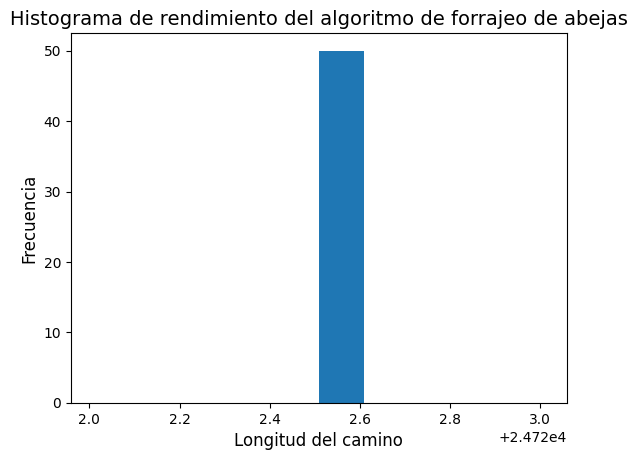

El grafo tiene 4504 nodos y 9702 aristas


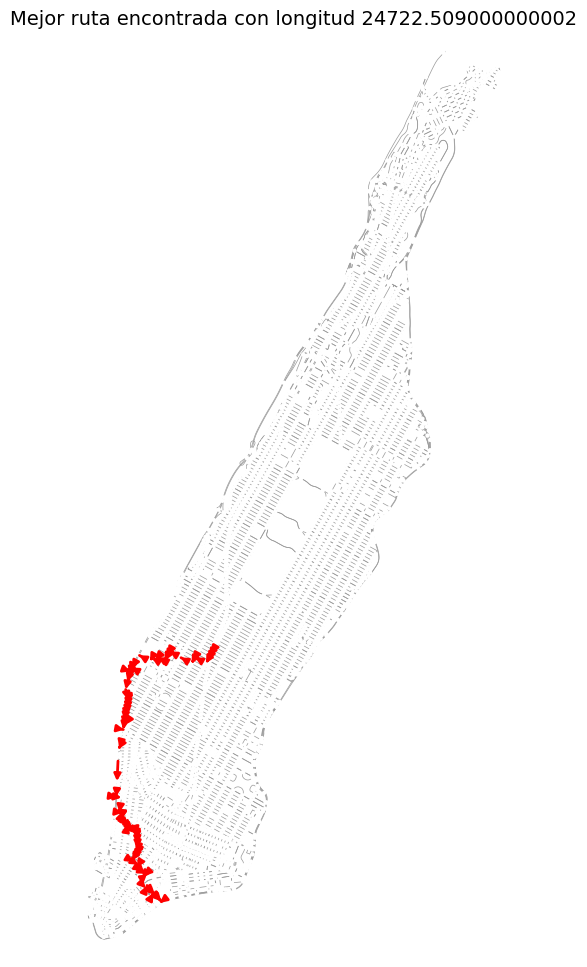

In [ ]:


def coords_to_node(G, coords):
    return ox.distance.nearest_nodes(G, coords[1], coords[0])

G_undirected = G.to_undirected()

start_coords = tuple(map(float, input("Introduce las coordenadas de inicio (lat, lon): ").split(',')))
end_coords = tuple(map(float, input("Introduce las coordenadas de fin (lat, lon): ").split(',')))

start_node = coords_to_node(G_undirected, start_coords)
end_node = coords_to_node(G_undirected, end_coords)

best_path, best_path_length = bee_algorithm(G_undirected, start_node, end_node)

if best_path:
    # Obtener las posiciones de los nodos
    node_positions = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}

    # Dibujar el grafo y la mejor ruta encontrada
    fig, ax = plt.subplots(figsize=(12, 12))
    ox.plot_graph(G, node_size=10, edge_linewidth=0.5, show=False, ax=ax)

    # Dibujar la mejor ruta encontrada
    best_route_edges = list(zip(best_path[:-1], best_path[1:]))
    nx.draw_networkx_edges(G, pos=node_positions, edgelist=best_route_edges, edge_color='r', width=2, ax=ax)

    plt.title(f"Mejor ruta encontrada con longitud {best_path_length}")
    print(f"El grafo tiene {G.number_of_nodes()} nodos y {G.number_of_edges()} aristas")
    plt.show()
else:
    print("No se encontró un camino entre los nodos seleccionados.")


Ingrese las coordenadas de inicio (lat, lon): 40.7580, -73.9855
Ingrese las coordenadas de fin (lat, lon): 40.7069, -74.0113


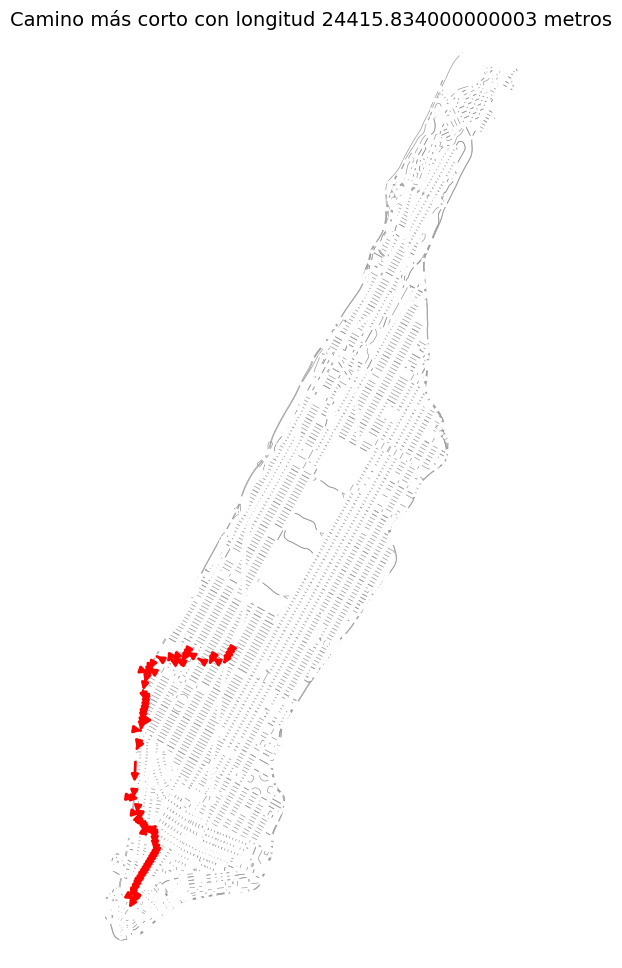

Nodo de inicio: 42428297
Nodo de fin: 42428368
Longitud del camino más corto: 24415.834000000003 metros


In [ ]:

def coords_to_node(G, coords):
    return ox.distance.nearest_nodes(G, coords[1], coords[0])

start_coords = tuple(map(float, input("Ingrese las coordenadas de inicio (lat, lon): ").split(',')))
end_coords = tuple(map(float, input("Ingrese las coordenadas de fin (lat, lon): ").split(',')))

# Convertir coordenadas a nodos en el grafo
start_node = coords_to_node(G_undirected, start_coords)
end_node = coords_to_node(G_undirected, end_coords)

# Aplicar el algoritmo de Dijkstra para encontrar el camino más corto con los parametros del grafo anterior
try:
    shortest_path = nx.shortest_path(G_undirected, source=start_node, target=end_node, weight='weight')
    shortest_path_length = nx.shortest_path_length(G_undirected, source=start_node, target=end_node, weight='weight')
except nx.NetworkXNoPath:
    print("No se encontró un camino entre los nodos seleccionados.")
    shortest_path = None
    shortest_path_length = None

# Obtener las posiciones de los nodos
node_positions = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}

# Dibujar el grafo y el camino más corto encontrado
fig, ax = plt.subplots(figsize=(12, 12))
ox.plot_graph(G, node_size=10, edge_linewidth=0.5, show=False, ax=ax)

if shortest_path:
    # Dibujar el camino más corto encontrado
    shortest_path_edges = list(zip(shortest_path[:-1], shortest_path[1:]))
    nx.draw_networkx_edges(G, pos=node_positions, edgelist=shortest_path_edges, edge_color='r', width=2, ax=ax)
    plt.title(f"Camino más corto con longitud {shortest_path_length} metros")
else:
    plt.title("No se encontró un camino entre los nodos seleccionados.")

plt.show()

if shortest_path:
    # Mostrar el nodo de inicio y fin
    print(f"Nodo de inicio: {start_node}")
    print(f"Nodo de fin: {end_node}")
    print(f"Longitud del camino más corto: {shortest_path_length} metros")